<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Forecasting - Previsões Para Séries Temporais - Modelos ARIMA</font></b></strong>

In [16]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [17]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

pandas      1.1.5
statsmodels 0.12.1
matplotlib  3.3.3
numpy       1.19.5
sklearn     0.24.0
Data Science Academy


## Definição do Problema de Negócio

Previsão do distanciamento social em Minas Gerais.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o distanciamento social em Minas Gerais. Os dados tem registros de 15/02/2020 a 29/01/2021.

Será fornecido 1 dataset com 2 colunas, data e distanciamento social.

In [18]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [19]:
# Dados
dataframe.head()

,QT_INTER
Data,
2020-02-15,31.6
2020-02-16,38.9
2020-02-17,24.0
2020-02-18,26.5
2020-02-19,27.8


In [20]:
dataframe.dtypes

QT_INTER    float64
dtype: object

In [21]:
dataframe.shape

(350, 1)

In [22]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

In [23]:
# Random seed 
np.random.seed(7)

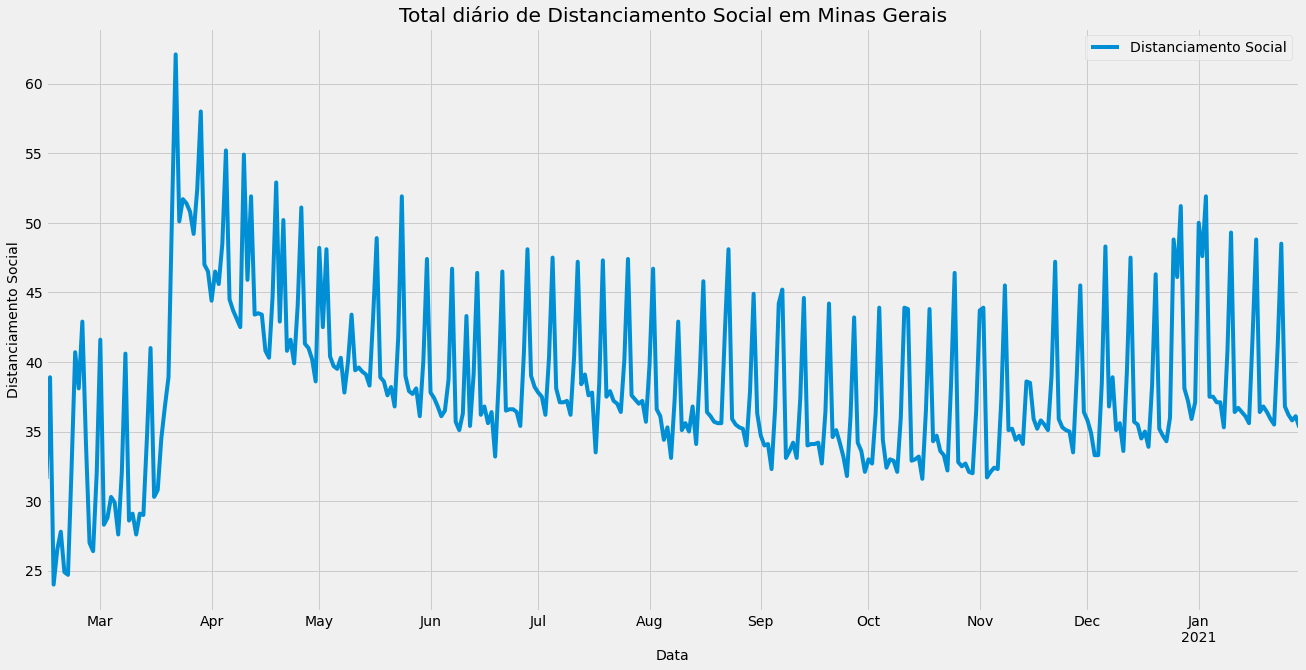

In [44]:
# Plot
target.plot(title = 'Total diário de Distanciamento Social em Minas Gerais', fontsize = 14, label = 'Distanciamento Social') 
plt.xlabel("Data") 
plt.ylabel("Distanciamento Social") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [25]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

262 88


Para Modelos ARIMA, devemos remover a tendência. Vamos fazer isso.

In [26]:
# Aplicando transformação de log
treino_log = np.log(treino) 

In [27]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
teste_log = np.log(teste)

Vamos testar a estacionaridade da série.

In [28]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 10).mean()
    rolstd = serie.rolling(window = 10).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

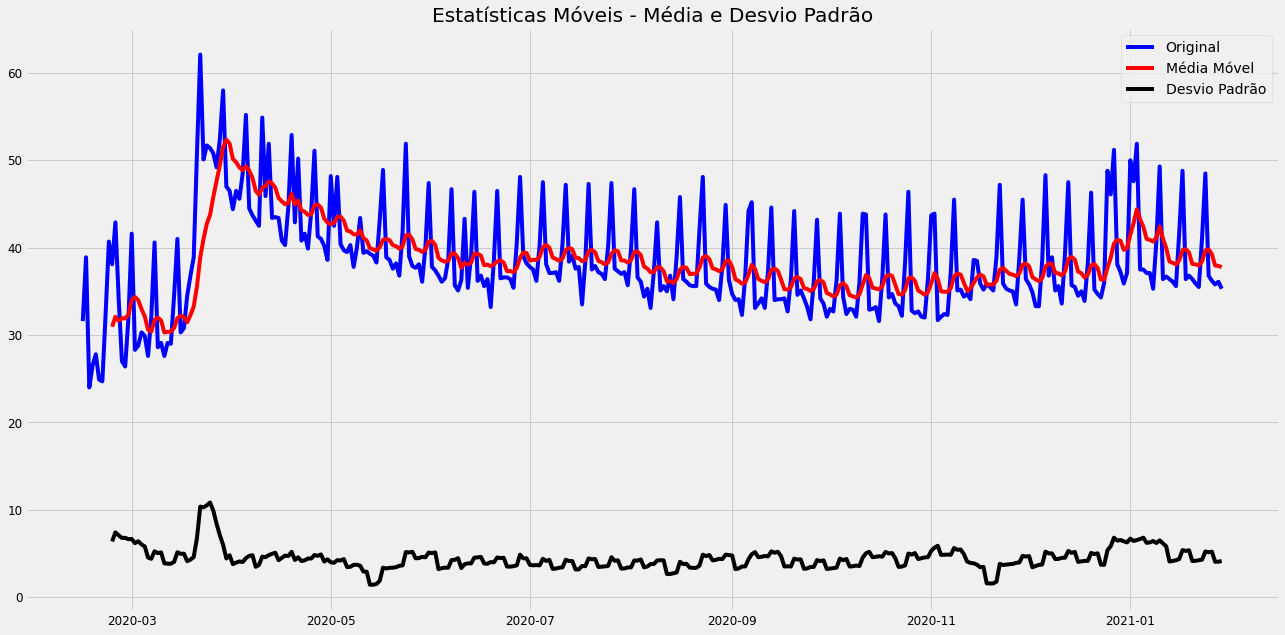


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -3.016851
Valor-p                           0.033350
Número de Lags Consideradas      14.000000
Número de Observações Usadas    335.000000
Valor Crítico (1%)               -3.450022
Valor Crítico (5%)               -2.870207
Valor Crítico (10%)              -2.571387
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [29]:
# Aplica a função 
testa_estacionaridade(dataframe['QT_INTER'])

O valor-p é menor que 0.05, portanto, não precisamos calcular o valor de 'd'. Ou seja, d = 0 no Modelo ARIMA.

Você rejeitará a hipótese nula e poderá inferir que a série temporal É ESTACIONÁRIA.

## Forecasting - Modelagem Preditiva Para Séries Temporais

### Modelo ARIMA

Vamos criar nosso primeiro Modelo ARIMA. Para começar vamos criar um modelo simples, treiná-los e fazer previsões e nos modelos seguintes vamos explorar os detalhes de Modelos ARIMA, como interpretar o resultado, os resíduos e melhorar o modelo.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

In [30]:
# Cria o Modelo ARIMA

# Definimos:

# p = 1
# d = 0
# q = 1

# Aqui o valor q é zero, pois é apenas o modelo AR. Nas próximas aulas eu explico porque.

# Modelo
modelo_AR = ARIMA(treino_log, order = (1, 0, 1))

Você pode estar se perguntando: Mas por que usamos os dados originais aqui? Não deveríamos usar a série diferenciada? 

De forma bem clara e objetiva, a resposta é: Não. 

Realizamos todas essas etapas de diferenciação e outras transformações para descobrir os coeficientes do modelo ARIMA. 

'I' no ARIMA significa Integração, que leva em consideração o número de dados diferenciados necessários para se tornar a série estacionária (ou seja, o Modelo ARIMA faz todo o trabalho). 

Realizamos essas etapas de diferenciação no início para encontra o valor ideal de "I". De fato, você deve comparar modelos diferentes com valores diferentes dessas variáveis para obter o melhor modelo.

O Pré-Processamento que fazemos nas séries temporais é para encontrar os melhores valores de p, d e q que colocamos aqui: order = (1, 0, 1).

Portanto, treinamos o modelo com TODOS os dados, a série inteira (dados de treino). Estudaremos isso nas aulas seguintes. 

In [31]:
# Treinamento
modelo_v1 = modelo_AR.fit(disp = -1)  

Vamos fazer previsões com o modelo.

In [32]:
# Sumário do Modelo - Nas próximas aulas vamos interpretar esse sumário do modelo
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               QT_INTER   No. Observations:                  262
Model:                     ARMA(1, 1)   Log Likelihood                 178.080
Method:                       css-mle   S.D. of innovations              0.123
Date:                Sat, 06 Feb 2021   AIC                           -348.161
Time:                        14:27:38   BIC                           -333.888
Sample:                    02-15-2020   HQIC                          -342.424
                         - 11-02-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.6381      0.023    158.253      0.000       3.593       3.683
ar.L1.QT_INTER     0.7290      0.095      7.687      0.000       0.543       0.915
ma.L1.QT_INTER    -0.1689      0.159     -1.063      0.288      -0.480       0.142
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3718           +0.0000j            1.3718            0.0000
MA.1            5.9206           +0.0000j            5.9206            0.0000
-----------------------------------------------------------------------------
"""

Agora vamos fazer previsões com o modelo treinado.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html

In [33]:
# Forecast
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
fc, se, conf = modelo_v1.forecast(len(teste_log), alpha = 0.05) 

In [34]:
# Previsões
fc

array([3.73061471, 3.70554478, 3.6872699 , 3.67394832, 3.66423747,
       3.65715869, 3.65199857, 3.64823707, 3.6454951 , 3.64349632,
       3.64203931, 3.6409772 , 3.64020298, 3.6396386 , 3.6392272 ,
       3.6389273 , 3.63870869, 3.63854933, 3.63843316, 3.63834848,
       3.63828676, 3.63824176, 3.63820896, 3.63818505, 3.63816762,
       3.63815491, 3.63814565, 3.6381389 , 3.63813398, 3.63813039,
       3.63812778, 3.63812587, 3.63812448, 3.63812347, 3.63812273,
       3.63812219, 3.6381218 , 3.63812151, 3.63812131, 3.63812115,
       3.63812104, 3.63812096, 3.6381209 , 3.63812086, 3.63812083,
       3.63812081, 3.63812079, 3.63812078, 3.63812077, 3.63812076,
       3.63812076, 3.63812075, 3.63812075, 3.63812075, 3.63812075,
       3.63812075, 3.63812075, 3.63812075, 3.63812075, 3.63812075,
       3.63812075, 3.63812075, 3.63812074, 3.63812074, 3.63812074,
       3.63812074, 3.63812074, 3.63812074, 3.63812074, 3.63812074,
       3.63812074, 3.63812074, 3.63812074, 3.63812074, 3.63812

In [35]:
# Erro
se

array([0.1225011 , 0.14040464, 0.14904571, 0.1534395 , 0.15572383,
       0.15692415, 0.15755824, 0.15789415, 0.15807236, 0.15816697,
       0.15821722, 0.15824391, 0.1582581 , 0.15826563, 0.15826964,
       0.15827177, 0.1582729 , 0.1582735 , 0.15827382, 0.15827399,
       0.15827408, 0.15827412, 0.15827415, 0.15827416, 0.15827417,
       0.15827417, 0.15827418, 0.15827418, 0.15827418, 0.15827418,
       0.15827418, 0.15827418, 0.15827418, 0.15827418, 0.15827418,
       0.15827418, 0.15827418, 0.15827418, 0.15827418, 0.15827418,
       0.15827418, 0.15827418, 0.15827418, 0.15827418, 0.15827418,
       0.15827418, 0.15827418, 0.15827418, 0.15827418, 0.15827418,
       0.15827418, 0.15827418, 0.15827418, 0.15827418, 0.15827418,
       0.15827418, 0.15827418, 0.15827418, 0.15827418, 0.15827418,
       0.15827418, 0.15827418, 0.15827418, 0.15827418, 0.15827418,
       0.15827418, 0.15827418, 0.15827418, 0.15827418, 0.15827418,
       0.15827418, 0.15827418, 0.15827418, 0.15827418, 0.15827

In [36]:
# Coeficientes
conf

array([[3.49051696, 3.97071246],
       [3.43035674, 3.98073281],
       [3.39514568, 3.97939412],
       [3.37321241, 3.97468422],
       [3.35902436, 3.96945058],
       [3.34959301, 3.96472436],
       [3.34319009, 3.96080705],
       [3.33877022, 3.95770392],
       [3.33567898, 3.95531122],
       [3.33349477, 3.95349788],
       [3.33193926, 3.95213936],
       [3.33082483, 3.95112958],
       [3.33002281, 3.95038315],
       [3.32944366, 3.94983354],
       [3.3290244 , 3.94942999],
       [3.32872034, 3.94913426],
       [3.32849951, 3.94891787],
       [3.32833897, 3.94875968],
       [3.32822218, 3.94864415],
       [3.32813717, 3.9485598 ],
       [3.32807527, 3.94849825],
       [3.32803018, 3.94845334],
       [3.32799733, 3.94842059],
       [3.32797339, 3.94839671],
       [3.32795594, 3.9483793 ],
       [3.32794323, 3.9483666 ],
       [3.32793397, 3.94835734],
       [3.32792721, 3.94835059],
       [3.32792229, 3.94834567],
       [3.3279187 , 3.94834208],
       [3.

In [37]:
# Precisamos criar um dataframe para criar o Plot
fc_series = pd.Series(fc, index = teste_log.index)
limite_inferior = pd.Series(conf[:, 0], index = teste_log.index)
limite_superior = pd.Series(conf[:, 1], index = teste_log.index)

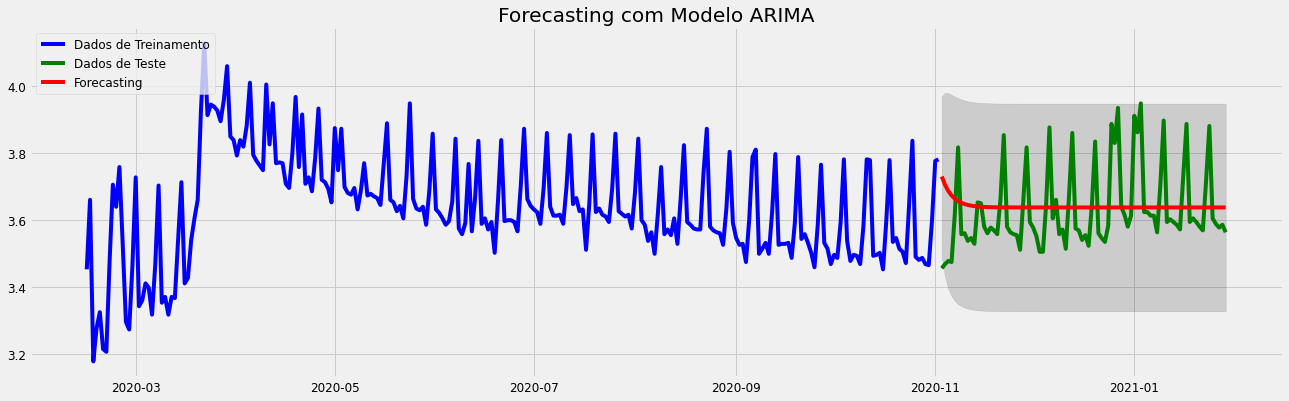

In [38]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino_log, label = 'Dados de Treinamento', color = 'blue')
plt.plot(teste_log, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting', color = 'red')
plt.fill_between(limite_inferior.index, limite_inferior, limite_superior, color = 'k', alpha = .15)
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

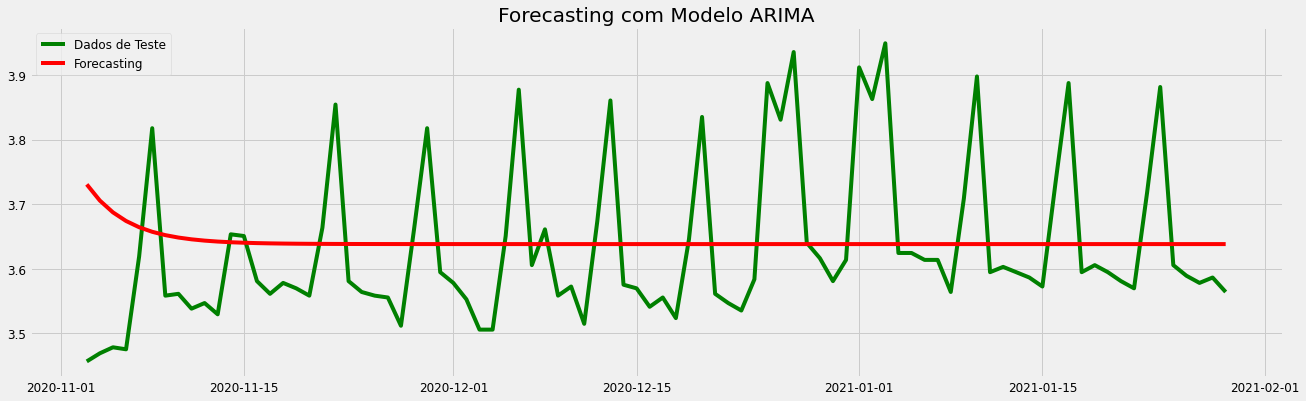

In [39]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste_log, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Pronto! Temos a previsão da nossa série! Nosso modelo está muito bom e poderia ser usado para resolver nosso problema de negócio.


In [40]:
# Define valor real e valor previsto
y_true = teste_log
y_pred = fc_series

In [41]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.1259334120349205


In [42]:
# Define valor real e valor previsto invertendo o LOG
y_true = np.exp(teste_log)
y_pred = np.exp(fc_series)

In [43]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

5.125362525139368


Não reduzimos o erro do nosso modelo. 

Aumentamos de 7.6327 (naive) para 8.7714 (previsoes_v2 modelo 12) e diminuimos para 5.1253 (modelo 13).

Você pode estar estranhando o gráfico, mas o que fizemos foi usar a série com a transformação de log, o que muda a escala dos dados. Porém os dados são os mesmos.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim